## Augmentation 적용

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 다운로드

In [3]:
(ds_train,ds_test),ds_info = tfds.load(
    'stanford_dogs',
    as_supervised=True,
    split=['train','test'],
    shuffle_files = True,
    with_info = True,
)

### 데이터 확인

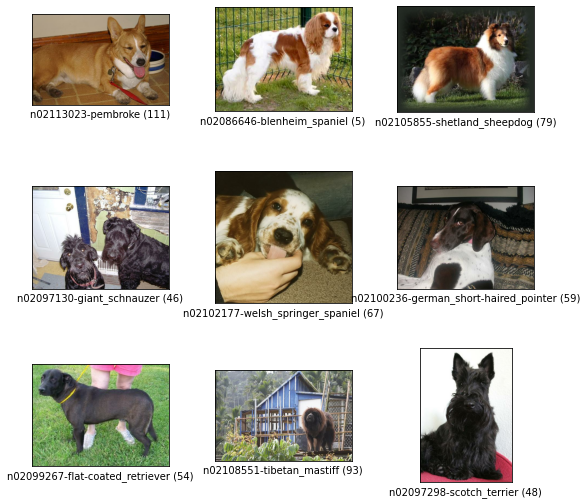

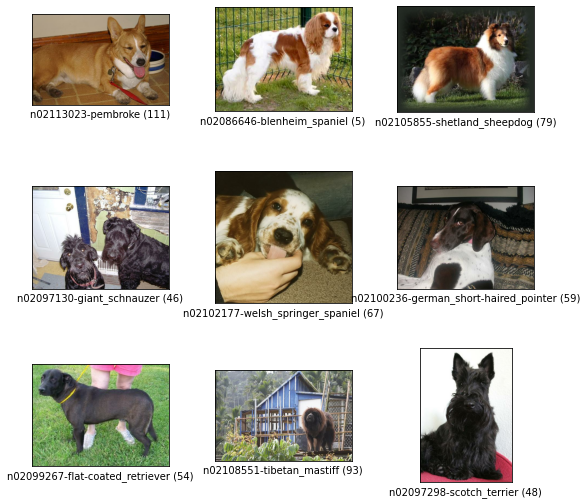

In [4]:
tfds.show_examples(ds_train,ds_info)

In [5]:
num_classes = ds_info.features["label"].num_classes

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [7]:
#aug 적응시키지 않은거
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
#aug 적응시킨거
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 이미지 섞기

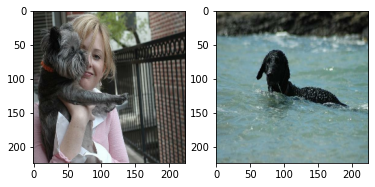

In [8]:
#데이터셋에서 이미지 2개 가져옴
for i,(image,label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)


## Cutmix Augmentation
- 일정 영역 잘라서 붙여 블렌딩 
- 이미지 섞는 부분 + 라벨을 섞어햠

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(24, shape=(), dtype=int32) tf.Tensor(196, shape=(), dtype=int32)
y :  tf.Tensor(52, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


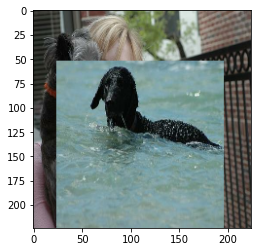

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 라벨 섞기

In [11]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5896046 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [13]:
# 기본 + cutmix augmentation
ds_train_cutmix = apply_normalize_on_dataset(ds_train, is_test=True, with_aug=False, with_cutmix=True, with_mixup=False)

## Mixup Augmentation

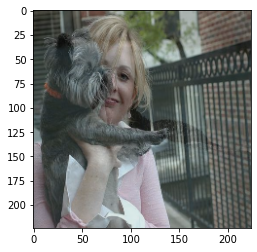

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.23157382 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [26]:
# 기본 + mixup augmentation
ds_train_mixup = apply_normalize_on_dataset(ds_train, is_test=True, with_aug=True, with_cutmix=False, with_mixup=True)

## 적용실험

- no aug

In [18]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [19]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 189s 200ms/step - loss: 2.1892 - accuracy: 0.4551 - val_loss: 3.6188 - val_accuracy: 0.1621
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.6998 - accuracy: 0.8049 - val_loss: 1.1212 - val_accuracy: 0.6753
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.2207 - accuracy: 0.9558 - val_loss: 0.9869 - val_accuracy: 0.7127
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0682 - accuracy: 0.9942 - val_loss: 0.9389 - val_accuracy: 0.7257
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0278 - accuracy: 0.9988 - val_loss: 0.9390 - val_accuracy: 0.7323
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0197 - accuracy: 0.9994 - val_loss: 0.9432 - val_accuracy: 0.7364
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0137 - accuracy: 0.9997 - val_loss: 0.9509 -

- 기본 aug

In [20]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 159s 202ms/step - loss: 2.2571 - accuracy: 0.4265 - val_loss: 3.1825 - val_accuracy: 0.2448
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.9280 - accuracy: 0.7330 - val_loss: 1.3106 - val_accuracy: 0.6214
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.5699 - accuracy: 0.8372 - val_loss: 1.0878 - val_accuracy: 0.6784
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.3016 - accuracy: 0.9246 - val_loss: 0.9629 - val_accuracy: 0.7169
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.1540 - accuracy: 0.9696 - val_loss: 1.0092 - val_accuracy: 0.7125
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0856 - accuracy: 0.9872 - val_loss: 0.9548 - val_accuracy: 0.7316
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0546 - accuracy: 0.9932 - val_loss: 0.9571 -

- cutmix data

In [22]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 153s 200ms/step - loss: 2.2664 - accuracy: 0.4334 - val_loss: 3.7861 - val_accuracy: 0.1514
Epoch 2/20
750/750 [==============================] - 167s 222ms/step - loss: 0.6389 - accuracy: 0.8308 - val_loss: 1.4910 - val_accuracy: 0.5761
Epoch 3/20
750/750 [==============================] - 151s 202ms/step - loss: 0.1728 - accuracy: 0.9751 - val_loss: 1.0175 - val_accuracy: 0.7046
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0583 - accuracy: 0.9964 - val_loss: 0.9626 - val_accuracy: 0.7284
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0290 - accuracy: 0.9992 - val_loss: 0.9645 - val_accuracy: 0.7274
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0181 - accuracy: 0.9998 - val_loss: 0.9701 - val_accuracy: 0.7305
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9749 -

In [24]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 153s 199ms/step - loss: 2.2639 - accuracy: 0.4298 - val_loss: 3.3612 - val_accuracy: 0.1941
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.6510 - accuracy: 0.8271 - val_loss: 1.1726 - val_accuracy: 0.6562
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.1787 - accuracy: 0.9737 - val_loss: 1.0104 - val_accuracy: 0.7070
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0568 - accuracy: 0.9971 - val_loss: 0.9661 - val_accuracy: 0.7234
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0282 - accuracy: 0.9989 - val_loss: 0.9506 - val_accuracy: 0.7315
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0188 - accuracy: 0.9994 - val_loss: 0.9929 - val_accuracy: 0.7242
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0140 - accuracy: 0.9997 - val_loss: 0.9649 -

## 시각화

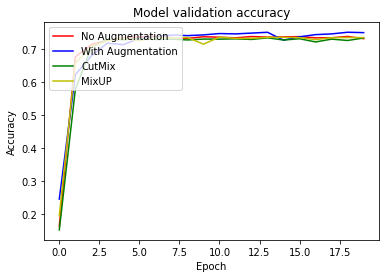

In [28]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix','MixUP'], loc='upper left')
plt.show()

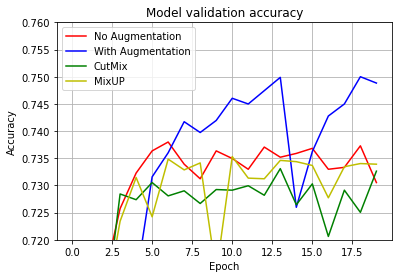

In [29]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix','MixUP'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 회고

,,,사진을 섞지 않은 기본 AUGMENTATION이 정확도가 가장 높다
그다음이 AUGMETATION을 하지 않은 기본 데이터셋의 정확도라니...
내가 잘못한 것 같다..

아니면 사진을 섞는 과정에서 강아지들을 중점으로 섞는ㄴ게 아니라 배경을 섞었을 수도..???? 아니면 훈련수를 높여서 더 돌려봐야하는건가...
훈련이 너무 오래걸린다
